In [59]:
import sys, os
PYTHON = %system which python
HOSTNAME = %system echo $HOSTNAME
print("python dir:     ",PYTHON)
print("HOSTNAME:       ",HOSTNAME)

sys.path.append('/Users/rezvanchitsazi/MachineLearning/Cannabinoid_receptor_1')
from lib import *

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


%load_ext autoreload
%autoreload 2

python dir:      ['/Users/rezvanchitsazi/opt/anaconda3/bin/python']
HOSTNAME:        ['[[Rezvans-MacBook-Pro.local]]']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

In [9]:
pwd

'/Users/rezvanchitsazi/MachineLearning/Cannabinoid_receptor_1'

# <font color=darkcyan> Original Data <font> 

In [10]:
pd.set_option('display.max_columns', None)
data=pd.read_csv('cb1.csv', sep=';')
data.to_csv('data.csv', index=False)
data.head(5)
data[['Standard Value','Standard Type']].head(5)

,Standard Value,Standard Type
0,28.8,Ki
1,NaN,EC50
2,10000.0,Ki
3,NaN,Ki
4,NaN,Ki


# <font color=darkcyan> Data Cleaning <font> 

In [11]:
data=pd.read_csv('data.csv', delimiter=',',usecols = ['Molecule ChEMBL ID','Molecular Weight','AlogP','Smiles'] )

data.dropna(subset=['Molecule ChEMBL ID','Molecular Weight','AlogP','Smiles'], inplace=True)
data = data[data['AlogP'].str.contains('None') == False]

data = data.rename(columns={'Molecule ChEMBL ID': 'ChEMBL ID','Molecular Weight':'MW'})

data['AlogP'] = data['AlogP'].astype(float)

In [12]:
data['Smiles'].head(5)

0    Cc1c(C(=O)c2cccc3ccccc23)c2cccc3c2n1[C@H](CN1C...
1    N#Cc1ccccc1CSc1nnc2c3ccccc3n(S(=O)(=O)c3ccccc3...
2    CCCCCn1cc(C(=O)NC2CCCCC2)c(=O)n2nc(-c3ccc(C)cc...
3           FC(F)(F)c1ccccc1CSc1nnc2c(n1)[nH]c1ccccc12
4    COC(=O)[C@H](Cc1ccccc1)NC(=O)c1c(C)n(CCN2CCOCC...
Name: Smiles, dtype: object

# <font color=darkcyan> Draw Molecules <font> 
> MolToMPL(m) - Generates a drawing of a molecule on a canvas of the Matplotlib plotting library. rdkit. Chem.

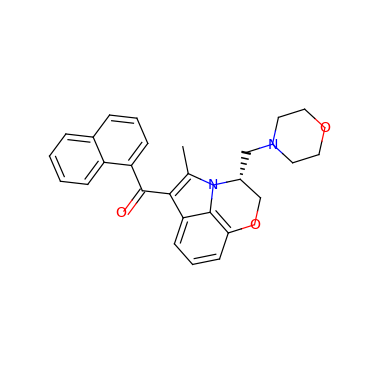

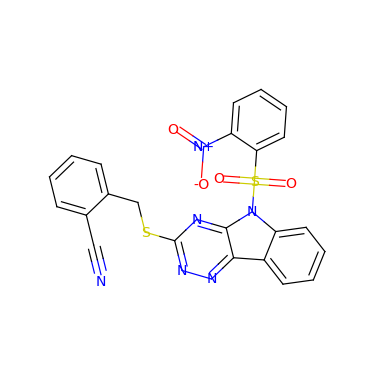

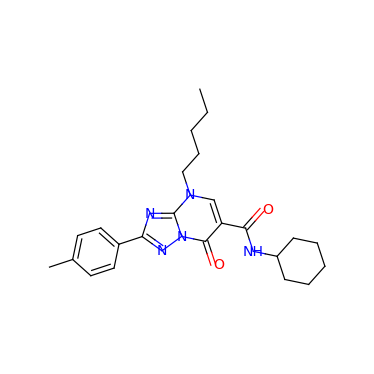

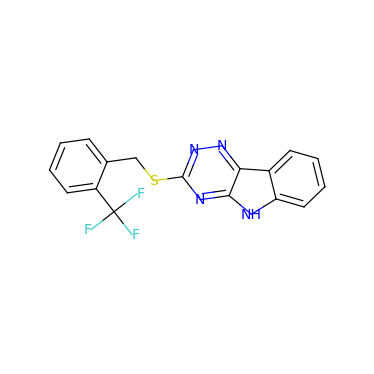

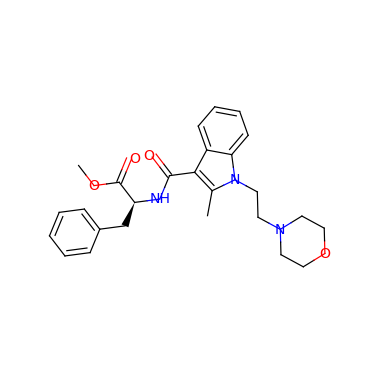

In [13]:
Smiles=data['Smiles']
mol_list = []
for smiles in Smiles[:5]:
    mol = Chem.MolFromSmiles(smiles)
    Draw.MolToMPL(mol, size=(200,200)) 
    plt.axis('off')

# <font color=darkcyan> Draw Molecules <font> 

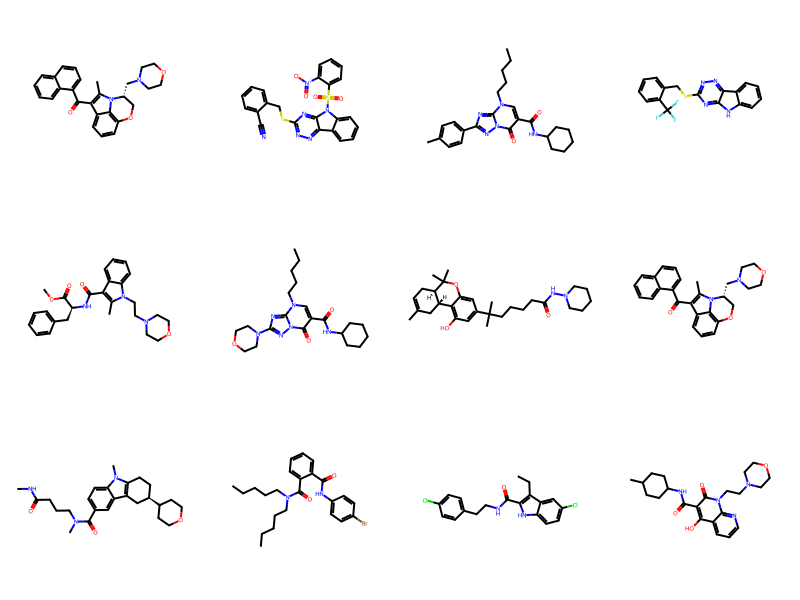

In [14]:
for smiles in Smiles[:12]:
    mol = Chem.MolFromSmiles(smiles)
    mol_list.append(mol)
mols2D = copy.deepcopy(mol_list)
for m in mols2D:
    AllChem.Compute2DCoords(m)
Draw.MolsToGridImage(mols2D[:12], useSVG=True, molsPerRow=4)

# <font color=darkcyan> AlogP: Target to predict <font> 
> Ghose-Crippen-Viswanadhan octanol-water partition coefficient (ALogP)
    
https://www.sailife.com/understanding-lipinskis-rule-of-5-and-the-role-of-logp-value-in-drug-design-and-development/

High lipophilicity (logP>5) often contributes to high metabolic turnover, low solubility, and poor oral absorption. In addition, highly lipophilic compounds tend to bind to hydrophobic targets other than the desired target, and, therefore, there is an increased risk of promiscuity and toxicity.

In [15]:
data['mol'] = data['Smiles'].apply(lambda x: Chem.MolFromSmiles(x))
print(len(data['mol']))

from molvs import Standardizer
s = Standardizer()
data['mol']=data['mol'].apply(lambda x: s.standardize(x)) 

data['mol'] = data['mol'].apply(lambda x: Chem.AddHs(x))
data['atoms'] = data['mol'].apply(lambda x: x.GetNumAtoms())
data['num_of_heavy_atoms'] = data['mol'].apply(lambda x: x.GetNumHeavyAtoms())

17674


# <font color=darkcyan> 0D Molecular Descriptors <font> 

In [18]:
def number_of_atoms(atom_list, data):
    for i in atom_list:
        data['{} atoms'.format(i)] = data['mol'].apply(lambda x : len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))
                                                            
                                                              
number_of_atoms(['C','O', 'N', 'F'], data)    

In [21]:
from scipy.stats import pearsonr
def corrfunc(x, y, ax=None, **kws):
    '''annotate the plots with the pearson correlation'''
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)  

<Figure size 1152x1152 with 0 Axes>

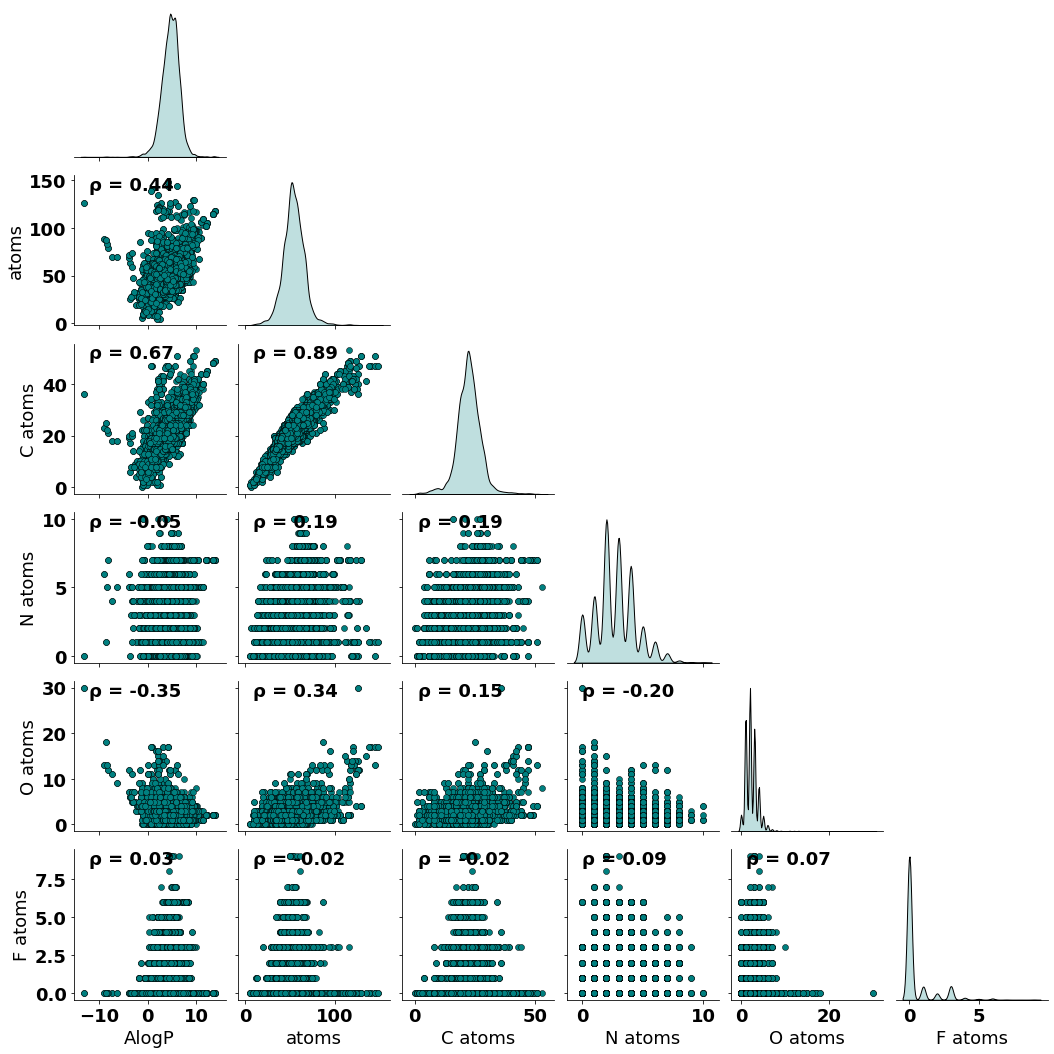

In [41]:
plt.figure(figsize=(16,16))
ax=sns.pairplot(data[['AlogP','MW','atoms', 'C atoms','N atoms','O atoms','F atoms']], 
                diag_kind='kde',
                diag_kws={'color':'teal', 'edgecolor':'k'}, plot_kws=dict(color='teal', edgecolor='k'), corner=True);
ax.map_lower(corrfunc)
plt.savefig('PairPlot.png');

In [44]:
from sklearn.model_selection import train_test_split
train_data=data.drop(columns=['Smiles','mol','AlogP','MW','ChEMBL ID'])
X=train_data
y=data['AlogP'].values
print('min ALogP: ', data['AlogP'].min())
print('max ALogP: ', data['AlogP'].max())
train_data.head(10)

min ALogP:  -13.05
max ALogP:  13.92


,atoms,num_of_heavy_atoms,C atoms,O atoms,N atoms,F atoms
0,58,32,27,3,2,0
1,49,35,23,4,6,0
2,62,31,24,2,5,0
3,36,25,17,0,4,3
4,64,33,26,4,3,0
5,62,30,21,3,6,0
6,78,34,29,3,2,0
7,58,32,27,3,2,0
8,66,31,25,3,3,0
9,60,29,24,2,2,0


# <font color=darkcyan> Test ML Models (Grid Search) <font> 

In [ ]:
Rmodel = GridSearchCV(Ridge(), cv=2,
              param_grid={"alpha": np.logspace(-10, -5, 30),}, scoring='neg_mean_absolute_error', n_jobs=-1)

Rmodel = Rmodel.fit(X, y)
Best_Ridge = Rmodel.best_estimator_
print("Best Ridge model")
print(Rmodel.best_params_)
print(-1*Rmodel.best_score_)

In [ ]:
RFmodel = GridSearchCV(RandomForestRegressor(), cv=2,
              param_grid={"n_estimators": np.linspace(50, 150, 25).astype('int')}, scoring='neg_mean_absolute_error', n_jobs=-1)

RFmodel = RFmodel.fit(X, y)
Best_RandomForestRegressor = RFmodel.best_estimator_
print("Best Random Forest model")
print(RFmodel.best_params_)
print(-1*RFmodel.best_score_)

In [ ]:
GPmodel = GridSearchCV(GaussianProcessRegressor(normalize_y=True), cv=2,
              param_grid={"alpha": np.logspace(-15, -10, 30),}, scoring='neg_mean_absolute_error', n_jobs=-1)
GPmodel = GPmodel.fit(X, y)
Best_GaussianProcessRegressor = GPmodel.best_estimator_
print("Best Gaussian Process model")
print(GPmodel.best_params_)
print(-1*GPmodel.best_score_)

MSE Train:  0.51
MSE Test:  0.52


<Figure size 432x288 with 0 Axes>

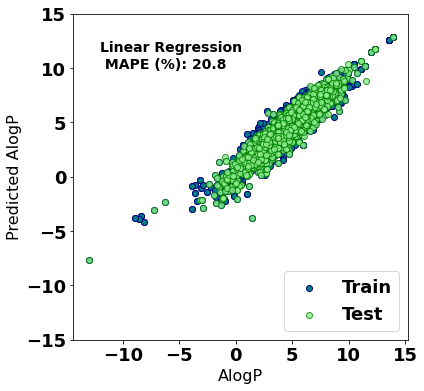

MSE Train:  0.51
MSE Test:  0.52


<Figure size 432x288 with 0 Axes>

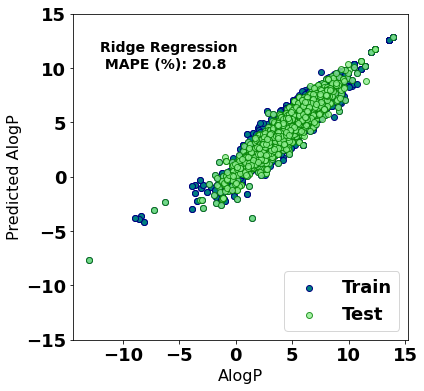

MSE Train:  0.065
MSE Test:  0.248


<Figure size 432x288 with 0 Axes>

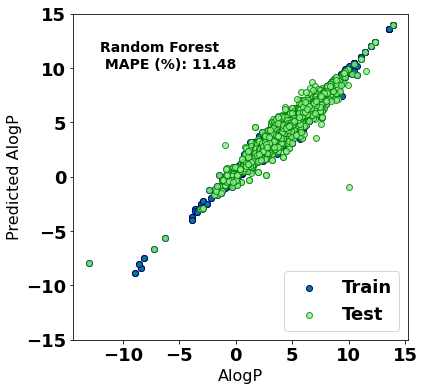

MSE Train:  0.506
MSE Test:  0.557


<Figure size 432x288 with 0 Axes>

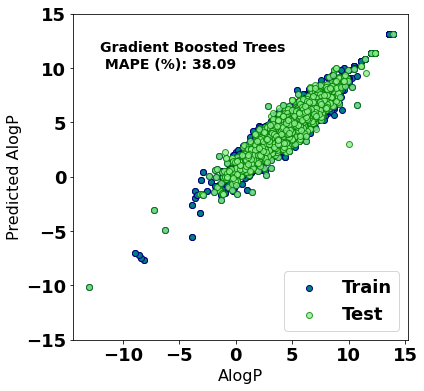

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

def test_models_and_plot(x, y, model_dict, plots=True):
    ''' inputs: 
            x: training data features, numpy array or Pandas dataframe
            y: training data labels, numpy array or Pandas dataframe
            model_dict: a dictionary of the form {name : model()}, where 'name' is a string
                        and 'model()' is a scikit-learn model object. 
    '''
    
    mean_scores = {}
    percent_errors = {}

    for (name, model) in model_dict.items():

        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=42 )

        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test  = model.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test =  mean_squared_error(y_test, y_pred_test)

        print('MSE Train: ', mse_train.round(3))
        print('MSE Test: ', mse_test.round(3))
        
        percent_error = np.mean( 100*np.abs(y_test -y_pred_test)/np.abs(y_pred_test))

        percent_errors[name] = percent_error

        fulltitle = name+'\n MAPE (%): '+str(round(percent_error,2))
        
        plt.clf()
        fontsize=16
        plt.figure(figsize=(6,6))
        plt.scatter(y_train,y_pred_train, label = 'Train', c='teal', edgecolors='navy')
        plt.xlabel('AlogP', fontsize=fontsize)
        plt.ylabel('Predicted AlogP', fontsize=fontsize)
        plt.scatter(y_test,y_pred_test,c='lightgreen', label='Test', alpha = 0.8, edgecolors='g')
        plt.ylim(-15, 15)
        plt.text(-12, 10, fulltitle, fontsize=14, bbox=dict(facecolor='white',edgecolor='white',alpha=0.75))
        plt.legend(loc=4)
        plt.savefig(name+'.png', dpi=2400, bbox_inches='tight')
        plt.show();


alpha_grid = {'alpha': np.logspace(1e-11,1e-1,8)}

model_dict = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': RidgeCV(cv=5),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosted Trees': GradientBoostingRegressor(n_estimators=100)}

test_models_and_plot(X, y, model_dict);

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42 )
rf = RandomForestRegressor(n_estimators=50, min_samples_leaf=25)
rf.fit(X_train, y_train)
y_train_predicted = rf.predict(X_train)
y_test_predicted_pruned_trees = rf.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_predicted)
mse_test = mean_squared_error(y_test, y_test_predicted_pruned_trees)
print("RF with pruned trees, Train MSE: {} Test MSE: {}".format(mse_train.round(3), mse_test.round(3)))

RF with pruned trees, Train MSE: 0.555 Test MSE: 0.635


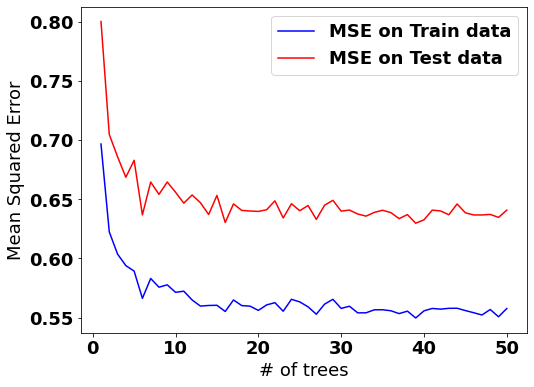

In [73]:
rf = RandomForestRegressor(n_estimators=1, min_samples_leaf=25, max_depth=50)
trees, train_loss, test_loss = [], [], []
for iter in range(50):
    rf.fit(X_train, y_train)
    y_train_predicted = rf.predict(X_train)
    y_test_predicted = rf.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_predicted)
    mse_test = mean_squared_error(y_test, y_test_predicted)
    #print("Iteration: {} Train mse: {} Test mse: {}".format(iter, mse_train, mse_test))
    trees += [rf.n_estimators]
    train_loss += [mse_train]
    test_loss += [mse_test]
    rf.n_estimators += 1
plt.figure(figsize=(8,6))  
plt.plot(trees, train_loss, color="blue", label="MSE on Train data")
plt.plot(trees, test_loss, color="red", label="MSE on Test data")
plt.xlabel("# of trees")
plt.ylabel("Mean Squared Error");
plt.legend()

17674
[9142, 6670, 7255, 5404, 8250]
5


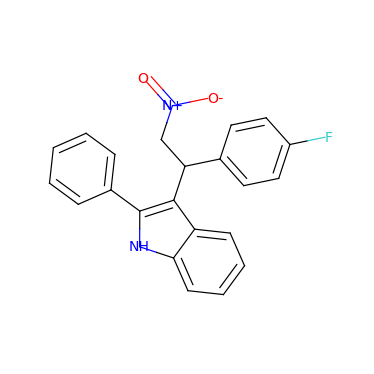

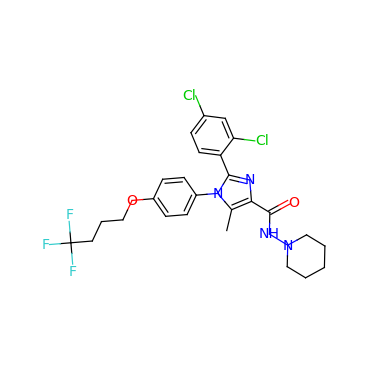

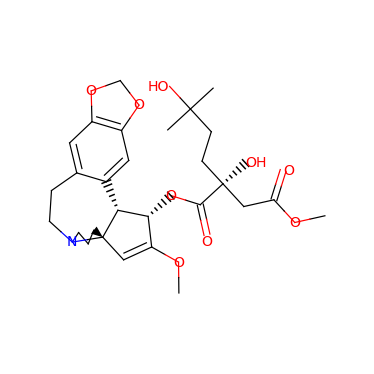

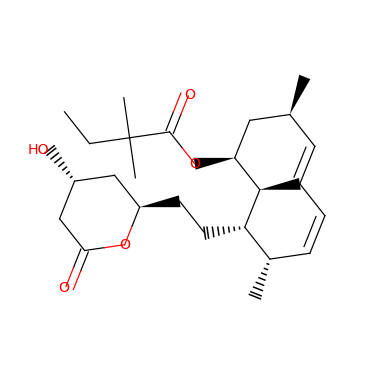

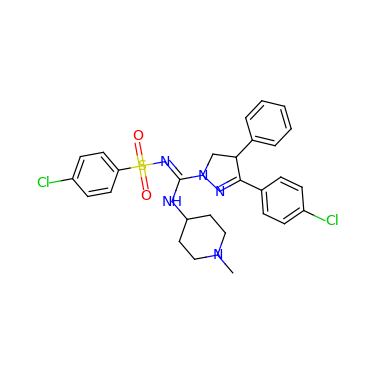

In [17]:
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

data['mol'] = data['Smiles'].apply(lambda x: Chem.MolFromSmiles(x))
print(len(data['mol']))
s = Standardizer()
data['mol']=data['mol'].apply(lambda x: s.standardize(x))
mol=data['mol']

fps = [GetMorganFingerprint(x,3) for x in data['mol']]
nfps = len(fps)

def distij(i,j,fps=fps):
    return 1-DataStructs.DiceSimilarity(fps[i],fps[j])

picker = MaxMinPicker()
pickIndices = picker.LazyPick(distij,nfps,5,seed=23)
print(list(pickIndices))


picks = [data['mol'][x] for x in pickIndices]
picks
print(len(picks))

mol2=data['mol'][6670]

div=[]
for i in range(len(picks)):
    diverse=data.loc[(data['mol'] == picks[i])]
    #print(diverse)
    
data_locked=data.loc[list(pickIndices)] 
#print(data_locked)
data_locked.to_csv('diverse.csv')


Draw.MolToFile(picks[0],'mol1.svg')    
Draw.MolToFile(picks[1],'mol2.svg') 
Draw.MolToFile(picks[2],'mol3.svg') 
Draw.MolToFile(picks[3],'mol4.svg') 
Draw.MolToFile(picks[4],'mol5.svg') 

for pkl in picks:
    Draw.MolToMPL(pkl, size=(200,200)) 
    plt.axis('off')

'''did a sanity check to make sure picked diverse molecules are the same'''
'markdown, change it to code and trt it again'
sanity_check=pd.read_csv('diverse.csv')
sanity_check

for m in sanity_check['Smiles']:
    mol = Chem.MolFromSmiles(m)
    Draw.MolToMPL(mol, size=(200,200)) 
    plt.axis('off')

# <font color=darkcyan> Taranabant <font>
> https://en.wikipedia.org/wiki/Taranabant

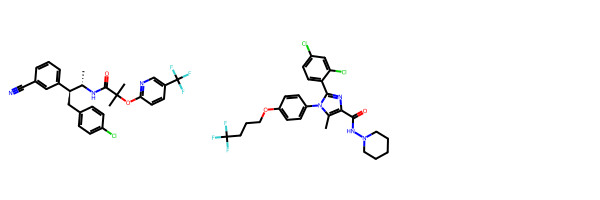

In [293]:
mol = Chem.MolFromSmiles('C[C@@H]([C@@H](CC1=CC=C(C=C1)Cl)C2=CC=CC(=C2)C#N)NC(=O)C(C)(C)OC3=NC=C(C=C3)C(F)(F)F')
d = rdMolDraw2D.MolDraw2DCairo(250, 200) 

d.drawOptions().addStereoAnnotation = True
d.drawOptions().addAtomIndices = True
Draw.MolToFile(mol,'Taranabant.svg') 

Draw.MolsToGridImage([mol, mol2])

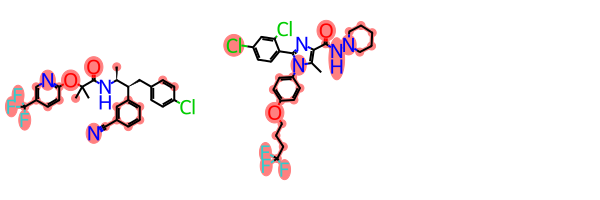

In [295]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import rdDepictor
rdDepictor.SetPreferCoordGen(True)
IPythonConsole.drawOptions.minFontSize=20

def view_difference(mol1, mol2):
    mcs = rdFMCS.FindMCS([mol1,mol2])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = mol1.GetSubstructMatch(mcs_mol)
    target_atm1 = []
    for atom in mol1.GetAtoms():
        if atom.GetIdx() not in match1:
            target_atm1.append(atom.GetIdx())
    match2 = mol2.GetSubstructMatch(mcs_mol)
    target_atm2 = []
    for atom in mol2.GetAtoms():
        if atom.GetIdx() not in match2:
            target_atm2.append(atom.GetIdx())
    return Draw.MolsToGridImage([mol1, mol2],highlightAtomLists=[target_atm1, target_atm2])

view_difference(mol,mol2)

# <font color=darkcyan> Morgan FP & Similarity <font> 

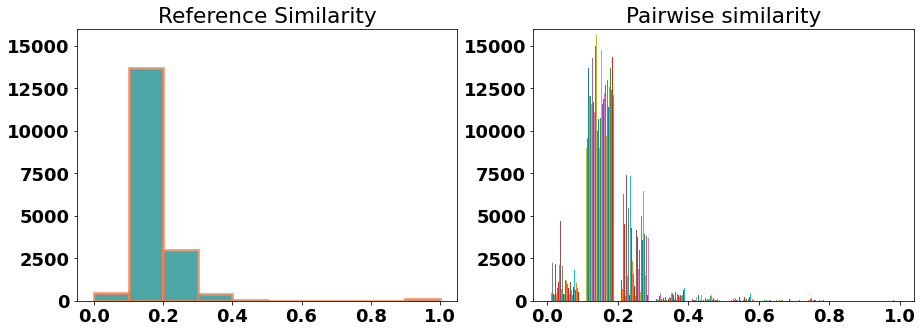

In [75]:
from rdkit.Chem import DataStructs,AllChem

mols_fps=[AllChem.GetMorganFingerprintAsBitVect(x,2,nBits=1024) for x in data['mol']]
#print(f'Tanimoto Similarity Coefficient of molecule_1 vs molecule_1: {DataStructs.TanimotoSimilarity(mols_fps[0],mols_fps[0])}')
#print(f'Tanimoto Similarity Coefficient of molecule_1 vs molecule_2: {DataStructs.TanimotoSimilarity(mols_fps[0],mols_fps[1])}')

'''Similarities to reference molecule'''
sim_ref = DataStructs.BulkTanimotoSimilarity(mols_fps[0],mols_fps)


'''Pairwise Similarities'''
def pairwise_sim(mols):
    pairwise=[]
    for i in mols:
        sim = DataStructs.BulkTanimotoSimilarity(i,mols)
        pairwise.append(sim)
    return pairwise
PW = pairwise_sim(mols_fps)


figure,(plt1,plt2) = plt.subplots(1,2)
figure.set_size_inches(15,5)


plt1.hist(sim_ref, color ='teal',edgecolor='coral',alpha = 0.7, linewidth=3)
plt1.set_title('Reference Similarity')
plt1.set_ylim([0, 16000])
plt.savefig('reference.png', dpi=2400)


plt2.hist(PW, linewidth=2)
plt2.set_title('Pairwise similarity')
plt2.set_ylim(0, 16000)
plt.savefig('similarity.png', dpi=2400)


In [ ]:
from rdkit.Chem import DataStructs,AllChem

mols_fps=[AllChem.GetMorganFingerprintAsBitVect(x,2,nBits=512) for x in data['mol']]
#print(f'Tanimoto Similarity Coefficient of molecule_1 vs molecule_1: {DataStructs.TanimotoSimilarity(mols_fps[0],mols_fps[0])}')
#print(f'Tanimoto Similarity Coefficient of molecule_1 vs molecule_2: {DataStructs.TanimotoSimilarity(mols_fps[0],mols_fps[1])}')

'''Similarities to reference molecule'''
sim_ref = DataStructs.BulkTanimotoSimilarity(mols_fps[0],mols_fps)



'''Pairwise Similarities'''
def pairwise_sim(mols):
    pairwise=[]
    for i in mols:
        sim = DataStructs.BulkTanimotoSimilarity(i,mols)
        pairwise.append(sim)
    return pairwise
PW = pairwise_sim(mols_fps)

figure,(plt1,plt2) = plt.subplots(1,2)
figure.set_size_inches(15,5)


plt1.hist(sim_ref, color ='teal',edgecolor='Navy',alpha = 0.7)
plt1.set_title('Reference Similarity')
plt1.set_ylim([0, 16000])

plt2.hist(PW)
plt2.set_title('Pairwise Similarity')
plt2.set_ylim(0, 16000)